# Skin Lesion Analyser (Skin Cancer Classification Based on Lesion Pigment)
---
    Skin cancer is a major public health problem with over 123,000 newly diagnosed cases worldwide in each year. Skin cancer is the most common form of cancer, globally accounting for at least 40% of cases. Skin cancer is diagnosed visually, beginning with an initial clinical screening and followed potentially by dermoscopic analysis, a biopsy and histopathological examination. Automated classification of skin lesions using images is a challenging task owing to the fine-grained variability in the appearance of skin lesions.

    The HAM10000 dataset consists of 10015 dermatoscopic images which are released as a training set for academic machine learning purposes and are publicly available through the ISIC archive. This benchmark dataset can be used for machine learning and for comparisons with human experts.

    It has 7 different classes of skin cancer which are listed below :
    1. Melanocytic nevi (nv) 4
    2. Melanoma (mel) 6
    3. Benign keratosis-like lesions (bkl) 2
    4. Basal cell carcinoma (bcc) 1
    5. Actinic keratoses (akiec) 0
    6. Vascular lesions (vasc) 5
    7. Dermatofibroma (df) 3

    Skin cancer lesion classification using the HAM10000 dataset

    Dataset link:
    https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000

    Dataset description: 
    https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

    Reference code for processing data: 
    https://www.kaggle.com/kmader/dermatology-mnist-loading-and-processing
    https://www.tensorflow.org/tutorials/structured_data/imbalanced_data



# Prepare all required library

In [1]:
!pip install -q kaggle
!pip install visualkeras

# !pip install keras==2.3.0
# !pip install tensorflow
# !pip install scikit-learn

     |████████████████████████████████| 992 kB 5.4 MB/s 


In [2]:
# Data Preparation
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np # for linear algebra

# Colab library to upload files to notebook
from google.colab import files

# Visualization lib
import pandas as pd # for data processing, CSV file I/O
import seaborn as sn
import json
import glob 
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

# Report Metrics 
from sklearn import metrics

# Model Development
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, LeakyReLU, GlobalMaxPooling2D, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from glob import glob
from PIL import Image
import visualkeras

# Download Dataset

In [3]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.18G/5.20G [00:30<00:00, 199MB/s]
100% 5.20G/5.20G [00:30<00:00, 181MB/s]


In [6]:
!unzip skin-cancer-mnist-ham10000.zip -d dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: dataset/ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: dataset/ham10000_images_part_2/ISIC_0029339.jp

In [7]:
!ls /content/dataset

ham10000_images_part_1	HAM10000_images_part_2	hmnist_28_28_RGB.csv
HAM10000_images_part_1	HAM10000_metadata.csv	hmnist_8_8_L.csv
ham10000_images_part_2	hmnist_28_28_L.csv	hmnist_8_8_RGB.csv


In [8]:
print(len(os.listdir("dataset/HAM10000_images_part_1")))
print(len(os.listdir("dataset/HAM10000_images_part_2")))

5000
5015


# Showing metadata of HAM10000 dataset

In [9]:
df_data = pd.read_csv('dataset/HAM10000_metadata.csv')

print('Metadata dataset')
df_data.head(10)

Metadata dataset


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


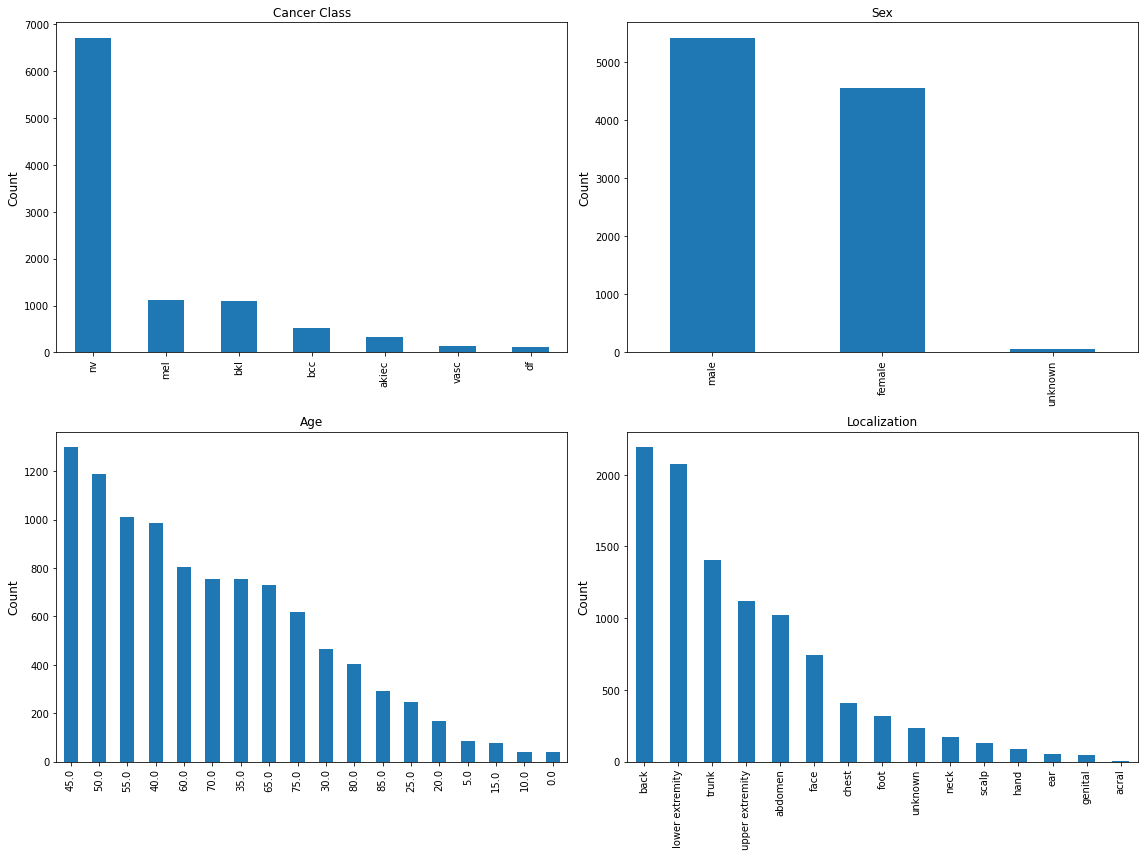

In [10]:
# visualization 
# Data distribution visualization
fig = plt.figure(figsize=(16,12))

class_plot = fig.add_subplot(221)
df_data['dx'].value_counts().plot(kind='bar', ax=class_plot)
class_plot.set_ylabel('Count', size=12)
class_plot.set_title('Cancer Class')

sex_plot = fig.add_subplot(222)
df_data['sex'].value_counts().plot(kind='bar', ax=sex_plot)
sex_plot.set_ylabel('Count', size=12)
sex_plot.set_title('Sex')

age_plot = fig.add_subplot(223)
df_data['age'].value_counts().plot(kind='bar')
age_plot.set_ylabel('Count',size=12)
age_plot.set_title('Age')

loc_plot = fig.add_subplot(224)
df_data['localization'].value_counts().plot(kind='bar')
loc_plot.set_ylabel('Count',size=12)
loc_plot.set_title('Localization')


plt.tight_layout()
plt.show()

In [11]:
# create one hot encoding

# Class Cancer yang terdapat pada dataset
class_cancer = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

sex_dict = {
    'female' : 0,
    'male' : 1
}
location_dict = {
'scalp' : 0 , 'ear' : 1, 'face' : 2, 'back' : 3, 'trunk' : 4, 'chest' : 5,
       'upper extremity' : 6, 'abdomen' : 7, 'unknown' : 8, 'lower extremity' : 9,
       'genital' : 10, 'neck' : 11, 'hand' : 12, 'foot' : 13, 'acral' :  14}

#create a modification dataframe
df_data['sex'] = df_data['sex'].map(sex_dict.get)
df_data['localization'] = df_data['localization'].map(location_dict.get)
df_data['lesion']= df_data.dx.map(class_cancer)
df_data['lesion_idx'] = pd.Categorical(df_data['lesion']).codes
df_data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion,lesion_idx
2080,HAM_0002375,ISIC_0027442,mel,histo,80.0,1.0,11,Melanoma,5
673,HAM_0006993,ISIC_0030310,bkl,histo,65.0,0.0,11,Benign keratosis,2
6726,HAM_0001684,ISIC_0029790,nv,histo,30.0,0.0,4,Melanocytic nevi,4
7968,HAM_0007052,ISIC_0033794,nv,histo,50.0,1.0,7,Melanocytic nevi,4
4732,HAM_0001586,ISIC_0030256,nv,follow_up,50.0,0.0,9,Melanocytic nevi,4


In [12]:
print('Kelas yang terdapat pada dataset awal :', df_data['dx'].unique())
print(df_data.lesion.value_counts())

Kelas yang terdapat pada dataset awal : ['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']
Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


## Checking null dataset

In [13]:
df_data.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex             57
localization     0
lesion           0
lesion_idx       0
dtype: int64

In [14]:
# # Cleaning the data
# df_data['age'].fillna((df_data['age'].mean()), inplace=True)
# df_data['sex'].fillna(df_data['sex'].value_counts().index[0], inplace=True)
# df_data.isnull().any()

In [15]:
# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/dataset/', '*', '*.jpg'))}
df_data['path'] = df_data['image_id'].map(imageid_path_dict.get)
df_data.sample(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,lesion,lesion_idx,path
4896,HAM_0006814,ISIC_0032264,nv,follow_up,40.0,1.0,4,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_2/ISIC_0...
2528,HAM_0000994,ISIC_0027545,bcc,histo,80.0,1.0,0,Basal cell carcinoma,1,/content/dataset/ham10000_images_part_1/ISIC_0...
6348,HAM_0003581,ISIC_0030051,nv,follow_up,40.0,1.0,4,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_2/ISIC_0...
2773,HAM_0005984,ISIC_0026117,bcc,histo,75.0,0.0,2,Basal cell carcinoma,1,/content/dataset/ham10000_images_part_1/ISIC_0...
6943,HAM_0007606,ISIC_0027907,nv,histo,70.0,0.0,13,Melanocytic nevi,4,/content/dataset/ham10000_images_part_1/ISIC_0...
590,HAM_0003605,ISIC_0029841,bkl,histo,55.0,1.0,2,Benign keratosis,2,/content/dataset/HAM10000_images_part_2/ISIC_0...
8231,HAM_0002661,ISIC_0025665,nv,histo,55.0,0.0,9,Melanocytic nevi,4,/content/dataset/ham10000_images_part_1/ISIC_0...
1488,HAM_0001409,ISIC_0026188,mel,histo,70.0,1.0,4,Melanoma,5,/content/dataset/ham10000_images_part_1/ISIC_0...
3276,HAM_0000329,ISIC_0031185,nv,follow_up,35.0,0.0,3,Melanocytic nevi,4,/content/dataset/HAM10000_images_part_2/ISIC_0...
5039,HAM_0005793,ISIC_0024629,nv,follow_up,65.0,1.0,4,Melanocytic nevi,4,/content/dataset/ham10000_images_part_1/ISIC_0...


In [16]:
# from skimage.io import imread
# df_data['image'] = df_data['path'].map(imread)

# Loading and resize images
df_data['image'] = df_data['path'].map(lambda x: np.asarray(Image.open(x).resize((64, 64)))) # pixels of image

# Checking the image size distribution
df_data['image'].map(lambda x: x.shape).value_counts()

(64, 64, 3)    10015
Name: image, dtype: int64

In [17]:
df_data['image'].head()

0    [[[191, 152, 194], [191, 153, 195], [192, 149,...
1    [[[23, 13, 23], [25, 14, 28], [37, 24, 46], [6...
2    [[[186, 129, 140], [192, 136, 151], [198, 143,...
3    [[[24, 11, 19], [36, 20, 30], [64, 38, 50], [9...
4    [[[139, 95, 118], [158, 114, 138], [178, 133, ...
Name: image, dtype: object

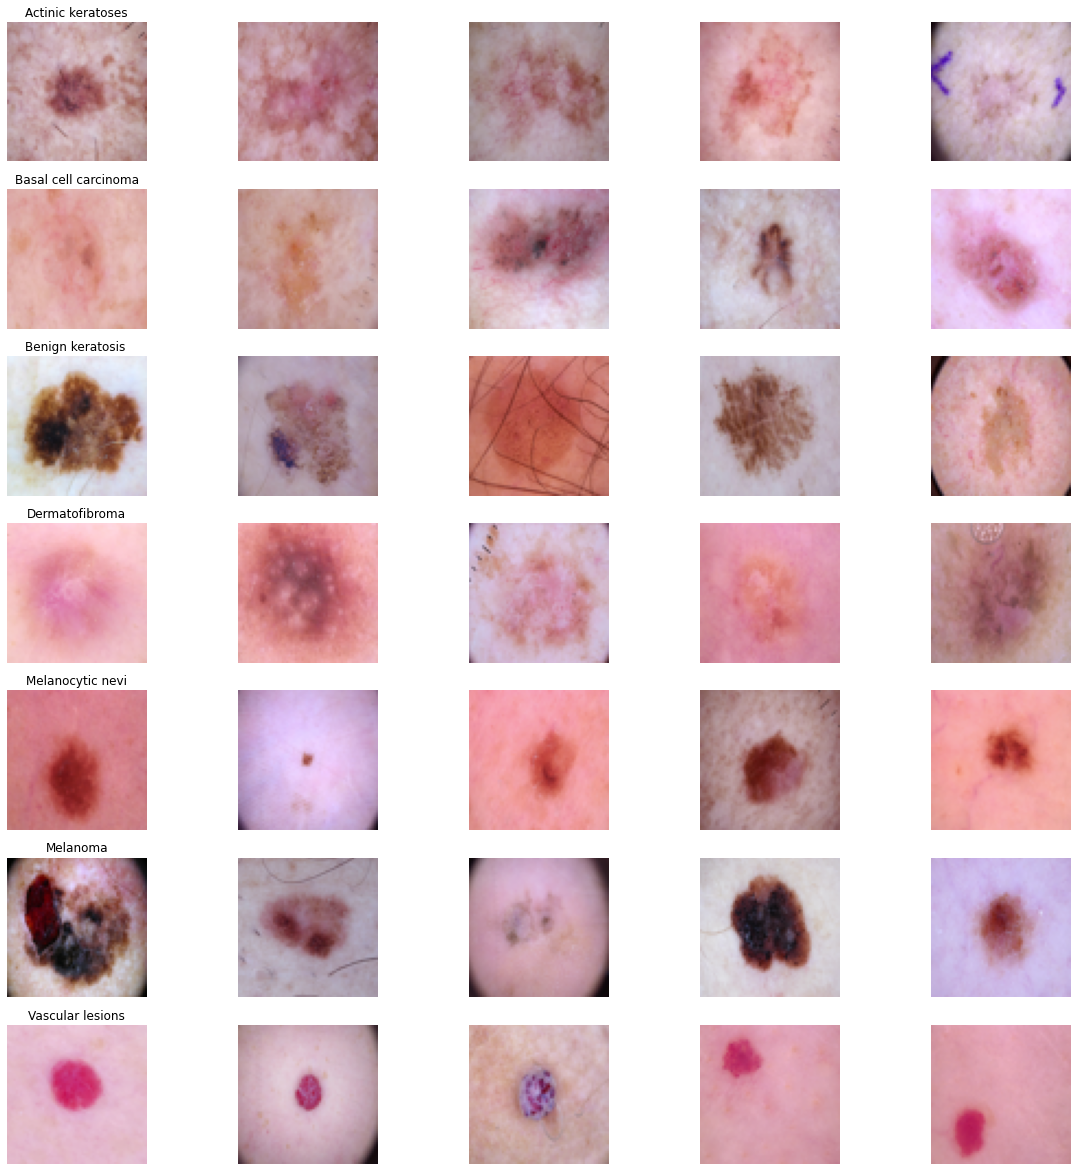

In [18]:
# Show image for each class cancer (dx)
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df_data.sort_values(['lesion']).groupby('lesion')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=10).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [19]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           9958 non-null   float64
 6   localization  10015 non-null  int64  
 7   lesion        10015 non-null  object 
 8   lesion_idx    10015 non-null  int8   
 9   path          10015 non-null  object 
 10  image         10015 non-null  object 
dtypes: float64(2), int64(1), int8(1), object(7)
memory usage: 792.3+ KB


In [20]:
df_data.to_csv ('metadata_skincancer.csv', index = False, header=True)

# Mengolah Model Menggunakan data hmnist_28_28_RGB.csv

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


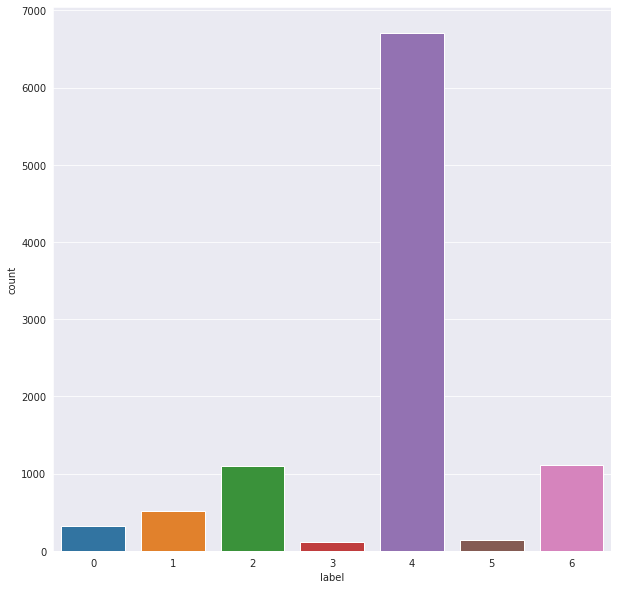

In [21]:
import seaborn as sns
import imblearn

# Load file CSV contains pixel values
Path = "/content/dataset/hmnist_28_28_RGB.csv"
DataSet = pd.read_csv(Path)
Label = DataSet["label"]
Data = DataSet.drop(columns=["label"]) 
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [22]:
# Resample the dataset
# PILIH SALAH SATU TEKNIK RESAMPLING YANG INGIN DIGUNAKAN (UNCOMMENT CODES TEKNIK YANG INGIN DIGUNAKAN)

# # Resampling Dataset Using Random Under Sampler
# from imblearn.under_sampling import RandomUnderSampler
# RUS = RandomUnderSampler(random_state=0)
# Data_balanced,Label_balanced = RUS.fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

# # Resampling Dataset Using Cluster Centroids
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.under_sampling import ClusterCentroids
# cc = ClusterCentroids(random_state=0)
# Data_balanced,Label_balanced = cc.fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

# # Resampling Dataset Using Random Over Sampler
# ROS = RandomOverSampler(random_state=42)
# Data_balanced,Label_balanced = ROS.fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

# # Resampling Dataset Using SMOTE
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)
# Data_balanced,Label_balanced = sm.fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

# # Resampling Dataset Using ADASYN
# from imblearn.over_sampling import ADASYN
# Data_balanced,Label_balanced = ADASYN().fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

# # Resampling Dataset Using Oversampling SMOTE + Undersampling Tomek Link
# from imblearn.combine import SMOTETomek 
# smt = SMOTETomek(random_state=0)
# Data_balanced,Label_balanced = smt.fit_resample(Data,Label)
# Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
# print('Shape of Data :', Data_balanced.shape)

### --- Dataset yang paling optimal ---- ###
# Resampling Dataset Using Oversampling SMOTE + Undersampling ENN
from imblearn.combine import SMOTEENN
smtn = SMOTEENN(random_state=42)
Data_balanced,Label_balanced = smtn.fit_resample(Data,Label)
Data_balanced = np.array(Data_balanced).reshape(-1,28,28,3)
print('Shape of Data :', Data_balanced.shape)

Shape of Data : (43473, 28, 28, 3)


In [23]:
DataSet["label"].value_counts().sort_index()

0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


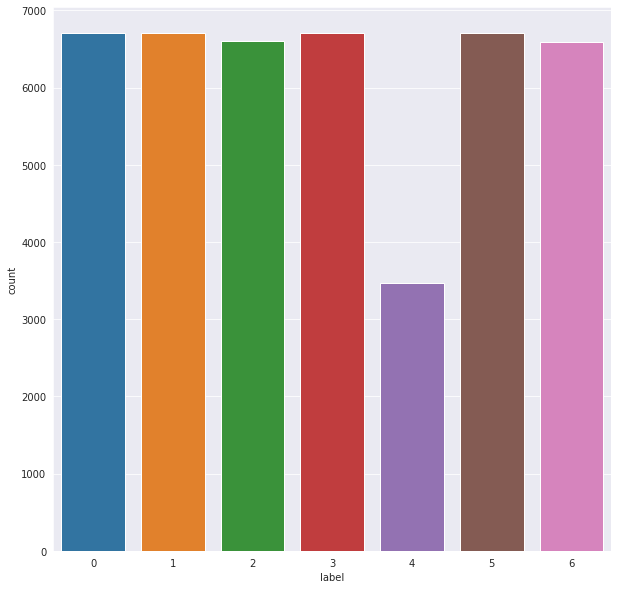

In [24]:
plt.figure(figsize = (10,10))
sns.set_style("darkgrid")
sns.countplot(Label_balanced)

In [25]:
pd.Series(Label_balanced).value_counts().sort_index()

0    6705
1    6702
2    6597
3    6705
4    3464
5    6705
6    6595
Name: label, dtype: int64

Counter({0: 6705, 3: 6705, 5: 6705, 1: 6702, 2: 6597, 6: 6595, 4: 3464})


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


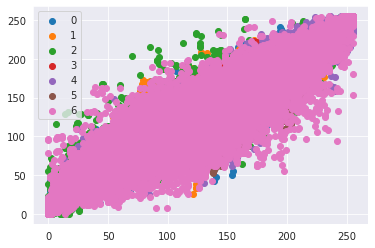

In [26]:
# Show scatter plot of balanced data
counter = Counter(Label_balanced)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
  row_ix = where(Label_balanced == label)[0]
  pyplot.scatter(Data_balanced[row_ix, 0], Data_balanced[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [27]:
Label_balanced = np.array(Label_balanced)
Label_balanced

array([0, 0, 0, ..., 6, 6, 6])

# Splitting data into 75% train data and 25% test data

In [28]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train , y_test = train_test_split(Data_balanced , Label_balanced , test_size = 0.25 , random_state = 42)

In [29]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(32604, 28, 28, 3)
(10869, 28, 28, 3)
(32604,)
(10869,)


# Convert labels into One-hot encoding

In [30]:
num_classes = 7
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [31]:
print("y_train")
print(y_train)
print("\n")
print("y_test")
print(y_test)

y_train
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


y_test
[[0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]]


[[[214 185 201]
  [216 186 200]
  [219 190 203]
  ...
  [212 176 185]
  [210 175 187]
  [208 177 189]]

 [[213 182 196]
  [217 187 199]
  [219 189 200]
  ...
  [215 181 193]
  [212 179 191]
  [210 178 191]]

 [[212 181 191]
  [218 187 198]
  [219 184 192]
  ...
  [217 184 199]
  [215 184 200]
  [212 180 195]]

 ...

 [[207 175 185]
  [207 174 184]
  [209 174 184]
  ...
  [208 172 190]
  [206 167 184]
  [204 170 185]]

 [[203 171 182]
  [206 174 184]
  [209 175 181]
  ...
  [207 173 187]
  [205 169 186]
  [203 170 186]]

 [[204 172 181]
  [209 178 189]
  [212 180 190]
  ...
  [207 173 186]
  [205 172 187]
  [205 173 190]]]
(28, 28, 3)


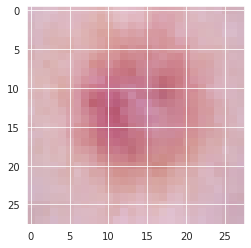

In [32]:
img = x_train[0]
print(img)
print(img.shape)
plt.imshow(img)

In [33]:
# Image Augementation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
  rotation_range=20,
  zoom_range=0.2,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  fill_mode="nearest")

In [34]:
""" Make a Model Architecture """

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# Reference Material : https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics
# Reference Material : https://rey1024.medium.com/mengenal-accuracy-precission-recall-dan-specificity-serta-yang-diprioritaskan-b79ff4d77de8
# Generally, the use of ROC curves and precision-recall curves are as follows:
# ROC curves should be used when there are roughly equal numbers of observations for each class.
# Precision-Recall curves should be used when there is a moderate to large class imbalance.

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias) 
  model = keras.models.Sequential([
  # model = Sequential()
  keras.layers.Conv2D(32, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'),
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  # model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu')
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.3),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Conv2D(256, kernel_size = (3,3), activation = 'relu', padding = 'same'),
  keras.layers.BatchNormalization(),
  # keras.layers.Dropout(0.2),
  keras.layers.MaxPool2D(pool_size = (2,2)),

  keras.layers.Flatten(),
  keras.layers.Dense(256, activation = 'relu'),
  # keras.layers.Dropout(0.25),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(128, activation = 'relu'),
  # keras.layers.Dropout(0.2),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(64, activation = 'relu'),
  # keras.layers.Dropout(0.15),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(32, activation = 'relu', kernel_regularizer=keras.regularizers.L1L2()),
  keras.layers.BatchNormalization(),
  keras.layers.Dense(7, activation='softmax')])
  
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=METRICS)

  return model

model = make_model()
# model.summary()

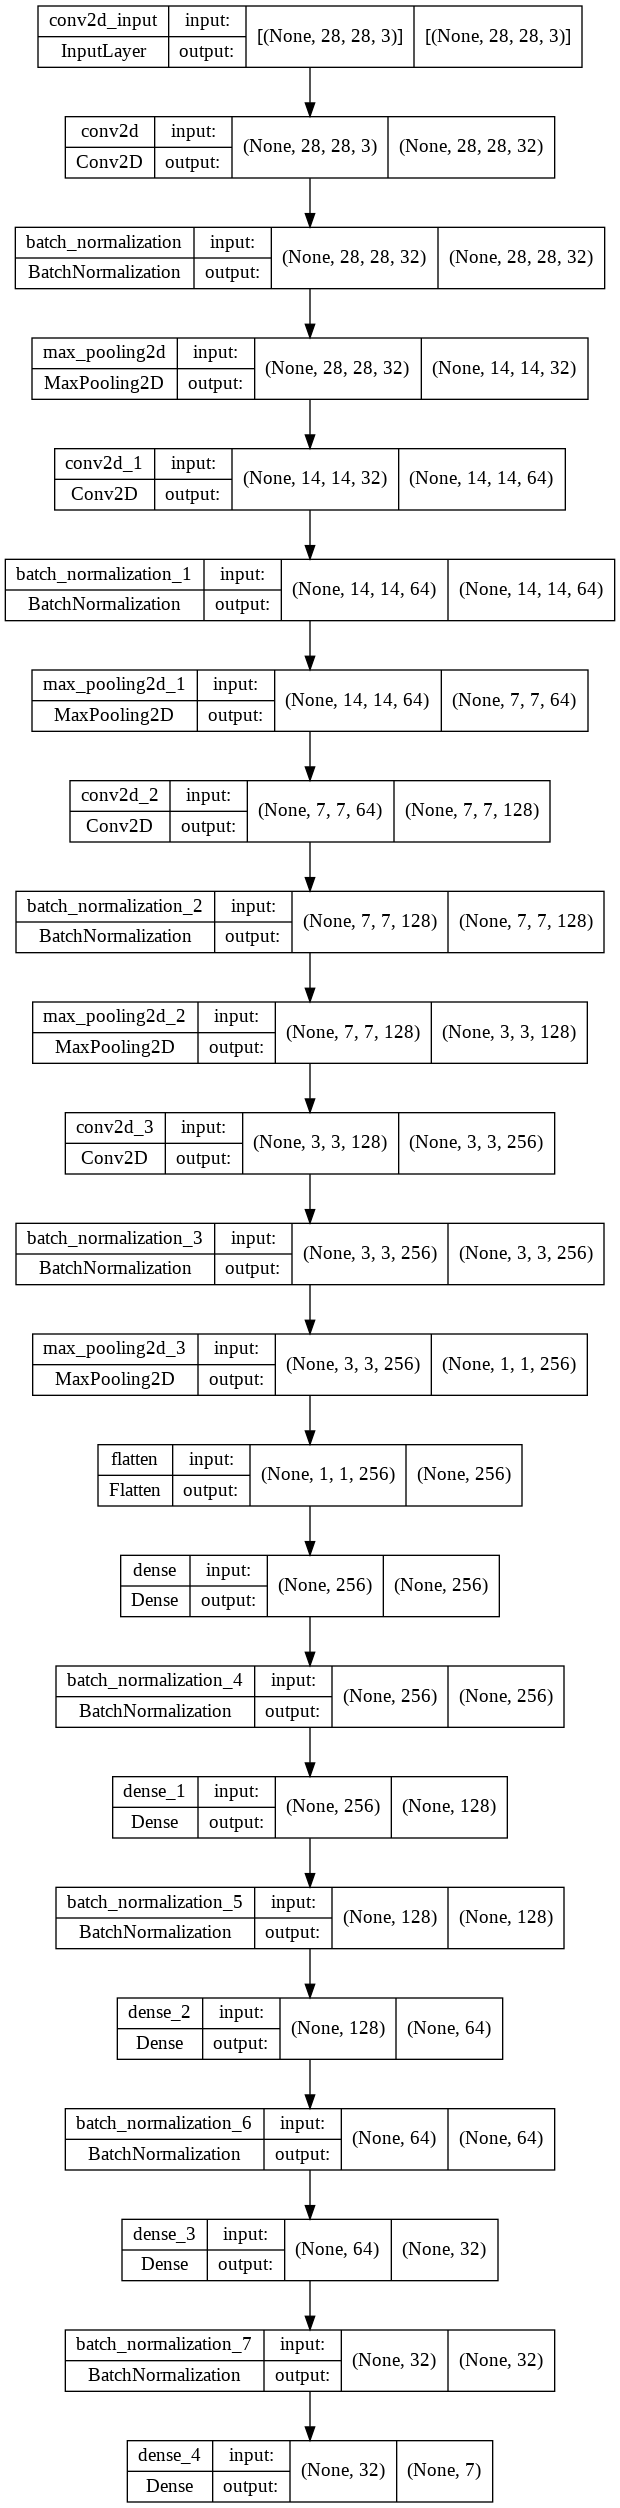

In [35]:
from keras.utils.vis_utils import plot_model
keras.utils.plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True, rankdir="TB", expand_nested = True, dpi = 96)

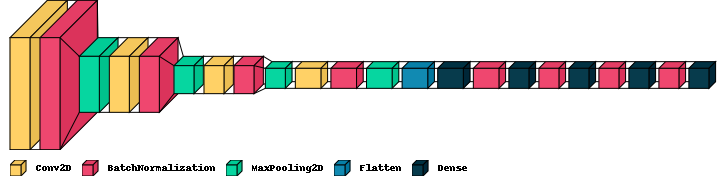

In [36]:
from PIL import ImageFont
font = ImageFont.load_default()
visualkeras.layered_view(model, legend=True, font=font, to_file='visualkeras.png')

## Set for callbacks

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# https://keras.io/api/callbacks/model_checkpoint/
checkpoint = ModelCheckpoint("best_model_cutix.h5", 
                             monitor='val_fn', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='min'
                             )

# https://keras.io/api/callbacks/reduce_lr_on_plateau/
learning_rate_reduction = ReduceLROnPlateau(monitor='val_recall',
                                            patience=10, 
                                            verbose=1, 
                                            # factor=0.35, #awal
                                            factor=0.45,
                                            min_lr=1e-10)

# https://keras.io/api/callbacks/early_stopping/
early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


# Training Model

In [38]:
history = model.fit(
    aug.flow(x_train, y_train,),
    epochs = 70,
    batch_size = 64,
    validation_data = (x_test, y_test), 
    # steps_per_epoch=len(x_train) // batch_size,
    # shuffle=True, # testing shuffle
    callbacks=[learning_rate_reduction, early_stopping, checkpoint])


Epoch 1/70
1018/1019 [============================>.] - ETA: 0s - loss: 1.0931 - tp: 14123.0000 - fp: 5252.0000 - tn: 190180.0000 - fn: 18449.0000 - accuracy: 0.8961 - precision: 0.7289 - recall: 0.4336 - auc: 0.8993 - prc: 0.6658
Epoch 1: val_fn improved from inf to 6004.00000, saving model to best_model_cutix.h5
1019/1019 [==============================] - 57s 42ms/step - loss: 1.0935 - tp: 14132.0000 - fp: 5261.0000 - tn: 190363.0000 - fn: 18472.0000 - accuracy: 0.8960 - precision: 0.7287 - recall: 0.4334 - auc: 0.8993 - prc: 0.6655 - val_loss: 1.2064 - val_tp: 4865.0000 - val_fp: 2912.0000 - val_tn: 62302.0000 - val_fn: 6004.0000 - val_accuracy: 0.8828 - val_precision: 0.6256 - val_recall: 0.4476 - val_auc: 0.8837 - val_prc: 0.6085 - lr: 0.0010
Epoch 2/70
1018/1019 [============================>.] - ETA: 0s - loss: 0.8391 - tp: 19304.0000 - fp: 5732.0000 - tn: 189700.0000 - fn: 13268.0000 - accuracy: 0.9167 - precision: 0.7710 - recall: 0.5927 - auc: 0.9411 - prc: 0.7749
Epoch 2: v

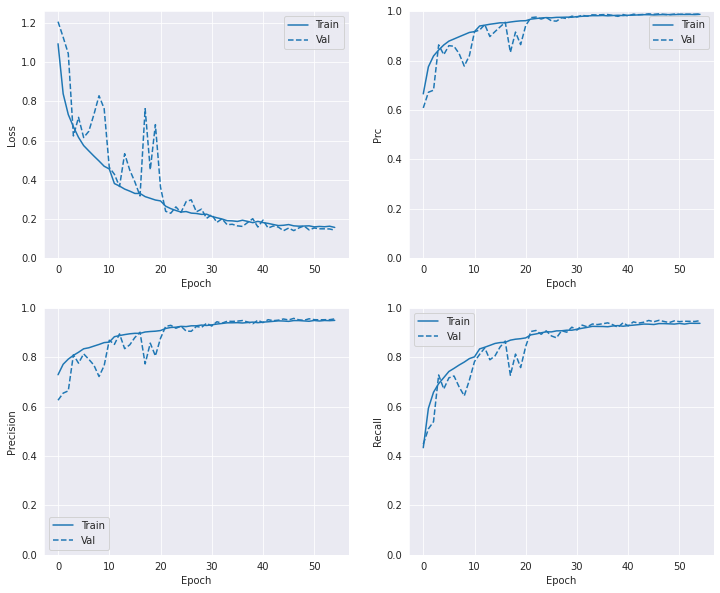

In [39]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(history)

# Evaluate Model Accuracy

In [40]:
score = model.evaluate(x_test, y_test)
print('loss :', score[0])
print('true positive : ', score[1])
print('false positive : ',score[2])
print('true negative : ',score[3])
print('false negative : ', score[4])
print('accuracy : ', score[5])
print('precision : ', score[6])
print('recall : ', score[7])
print('auc : ', score[8])

340/340 [==============================] - 4s 11ms/step - loss: 0.1406 - tp: 10308.0000 - fp: 493.0000 - tn: 64721.0000 - fn: 561.0000 - accuracy: 0.9861 - precision: 0.9544 - recall: 0.9484 - auc: 0.9976 - prc: 0.9893
loss : 0.14061008393764496
true positive :  10308.0
false positive :  493.0
true negative :  64721.0
false negative :  561.0
accuracy :  0.9861464500427246
precision :  0.9543560743331909
recall :  0.9483852982521057
auc :  0.9976033568382263


# Visualization Accuracy and Validation Accuracy Model

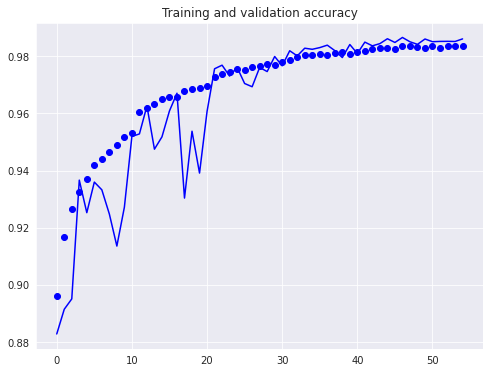

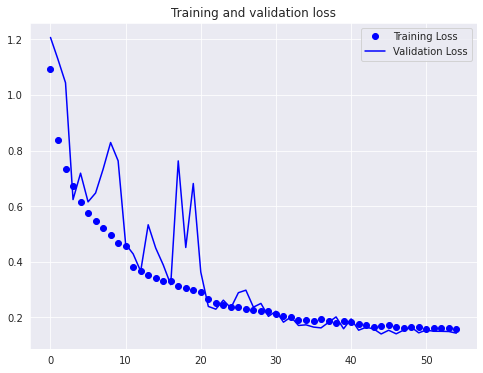

In [41]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(8,6))
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure(figsize=(8,6))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Using Function of Model Predict

In [42]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

# Save Model

In [43]:
import time
saved_model_path = "./model_cutix.h5"
model.save(saved_model_path)

# Classification Report 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.96      0.97      0.96      1754
                             ('bcc', ' basal cell carcinoma')       0.97      0.96      0.96      1686
                     ('bkl', 'benign keratosis-like lesions')       0.93      0.85      0.89      1629
                                     ('df', 'dermatofibroma')       0.99      1.00      1.00      1612
                                  ('nv', ' melanocytic nevi')       0.95      0.92      0.94       864
                               ('vasc', ' vascular lessions')       1.00      1.00      1.00      1625
                                          ('mel', 'melanoma')       0.88      0.92      0.90      1699

                                                    micro avg       0.95      0.95      0.95     10869
                                                    macro avg       0.9

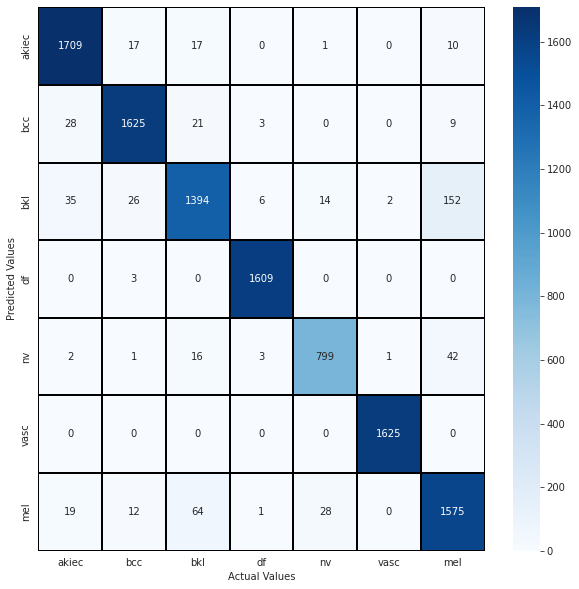

In [44]:
from sklearn.metrics import classification_report
Y_pred = model.predict(x_test).round()
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' vascular lessions'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test, Y_pred, target_names = target_names ))

from sklearn.metrics import confusion_matrix
f, ax = plt.subplots(figsize=(10,10))
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
cm_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='', 
            yticklabels = cm_labels,
            xticklabels = cm_labels, ax=ax)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

# Upload Photo for Testing Classification

In [46]:
 from tensorflow.keras.preprocessing import image
 from google.colab import files

 uploaded = files.upload()

 for fn in uploaded.keys():
 
   # predicting images
   path = fn
   img = image.load_img(path, target_size=(28, 28))
   x = image.img_to_array(img)
   x = np.expand_dims(x, axis=0)

   images = np.vstack([x])
   classes = model.predict(images, batch_size=10)
   print(fn)
   print(classes)

   cancer_class = np.argmax(classes)

   if cancer_class == 0:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) akiec')

   elif cancer_class == 1:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) bcc')

   elif  cancer_class == 2:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) bkl')

   elif  cancer_class == 3:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) df')

   elif cancer_class == 4:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) nv')

   elif cancer_class == 5:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) vasc')

   elif cancer_class == 6:
     print('Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) mel')

Saving ISIC_0024332.jpg to ISIC_0024332.jpg
ISIC_0024332.jpg
[[6.6446021e-02 9.0030605e-01 2.1220861e-02 1.2565581e-03 9.1100796e-05
  1.3522309e-04 1.0544255e-02]]
Penyakit yang anda alami diprediksi adalah Kanker Kulit yang termasuk dalam kelas (jenis) bcc
